In [2]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

Plots.GRBackend()

## Generate the (noisy) training dataset from:


## $$
\begin{aligned}
  \dot{x} &= \mu x - \omega y + A_{1} x(x^{2} + y^{2})\\
  \dot{y} &=  \mu y + \omega y + A_{2} y(x^{2} + y^{2})\\
  A_{1} &= A_{2}
\end{aligned}
$$

In [3]:
function Hopf2D(du, u, p, t)
    μ, ω, A1, A2 = p
    du[1] = μ*u[1] - ω*u[2] + A1*u[1]*(u[1]^(2) + u[2]^(2))
    du[2] = μ*u[2] + ω*u[1] + A2*u[2]*(u[1]^(2) + u[2]^(2))
end


# Define the experimental parameter

tspan = (0.0f0, 4.0f0)
u0 = Float32[-0.2, 0.2]
p_ = Float32[0.8, 1.2, -1.5, -1.5]

prob = ODEProblem(Hopf2D, u0, tspan, p_)

solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.1)


X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-4)*randn(eltype(X), size(X));

Generate noisy data


## Plot The Training Dataset

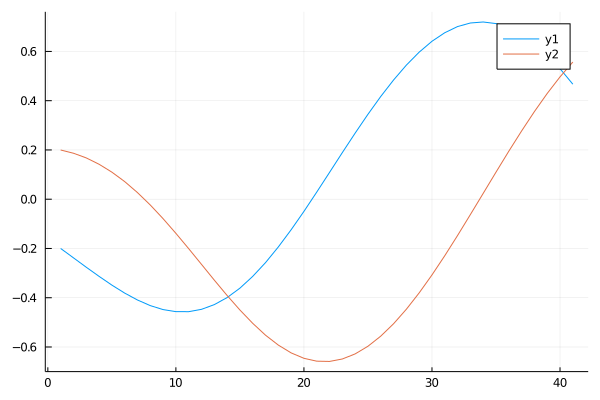

In [4]:
#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])
plot(Xₙ[1, :])
plot!(Xₙ[2, :])

## UADE

In [5]:
# Neural network

L = FastChain(FastDense(2, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 2))
p = initial_params(L)


# ODE

function dudt_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x - p_[2]*y + z[1],
    p_[2]*x + p_[1]*y + z[2]]
end

# ODE problem

prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = solution.t);

## PLot The Untrained Solution

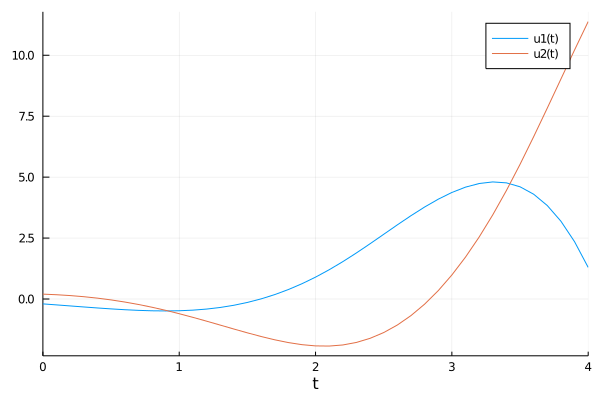

In [6]:
plot(sol_nn)
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss Function

In [7]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = solution.t,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

## Training With ADAM

In [8]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 200)

loss: 16.1:   5%|██                                     |  ETA: 0:02:15

Current loss after 10 iterations: 16.144943


loss: 13.1:  10%|████                                   |  ETA: 0:01:51

Current loss after 20 iterations: 13.074199


loss: 12.2:  15%|██████                                 |  ETA: 0:01:43

Current loss after 30 iterations: 12.203234


loss: 12:  20%|█████████                                |  ETA: 0:01:33

Current loss after 40 iterations: 11.988824


loss: 11.9:  25%|██████████                             |  ETA: 0:01:26

Current loss after 50 iterations: 11.918976


loss: 11.8:  30%|████████████                           |  ETA: 0:01:21

Current loss after 60 iterations: 11.800902


loss: 11.6:  35%|██████████████                         |  ETA: 0:01:14

Current loss after 70 iterations: 11.640125


loss: 11.4:  40%|████████████████                       |  ETA: 0:01:08

Current loss after 80 iterations: 11.441285


loss: 11.2:  45%|██████████████████                     |  ETA: 0:01:02

Current loss after 90 iterations: 11.172333


loss: 10.8:  50%|████████████████████                   |  ETA: 0:00:56

Current loss after 100 iterations: 10.801319


loss: 10.3:  55%|██████████████████████                 |  ETA: 0:00:50

Current loss after 110 iterations: 10.286333


loss: 9.58:  60%|████████████████████████               |  ETA: 0:00:45

Current loss after 120 iterations: 9.577417


loss: 8.64:  65%|██████████████████████████             |  ETA: 0:00:39

Current loss after 130 iterations: 8.635175


loss: 7.31:  70%|████████████████████████████           |  ETA: 0:00:33

Current loss after 140 iterations: 7.3132706


loss: 4.9:  75%|███████████████████████████████         |  ETA: 0:00:28

Current loss after 150 iterations: 4.895395


loss: 2.16:  80%|████████████████████████████████       |  ETA: 0:00:23

Current loss after 160 iterations: 2.1556888


loss: 1.35:  85%|██████████████████████████████████     |  ETA: 0:00:17

Current loss after 170 iterations: 1.3509101


loss: 0.445:  90%|███████████████████████████████████   |  ETA: 0:00:11

Current loss after 180 iterations: 0.44519523


loss: 0.105:  95%|█████████████████████████████████████ |  ETA: 0:00:06

Current loss after 190 iterations: 0.105304696


loss: 0.0502: 100%|█████████████████████████████████████| Time: 0:01:49


Current loss after 200 iterations: 0.050180413


 * Status: success

 * Candidate solution
    Final objective value:     5.018041e-02

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   162  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


## Training with BFGS

In [9]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 10000)

Current loss after 210 iterations: 0.016176011
Current loss after 220 iterations: 0.0016732526
Current loss after 230 iterations: 0.0003684275
Current loss after 240 iterations: 9.9765915e-5
Current loss after 250 iterations: 8.248404e-5
Current loss after 260 iterations: 4.364176e-5


 * Status: success

 * Candidate solution
    Final objective value:     4.358079e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.75e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.19e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.14e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   66  (vs limit Inf)
    Iterations:    63
    f(x) calls:    401
    ∇f(x) calls:   401


## Plot The Prediction

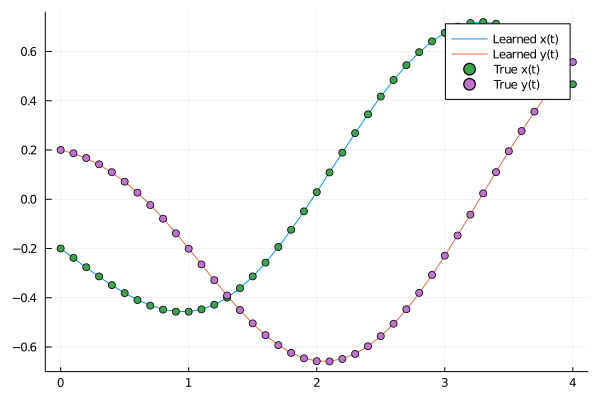

In [10]:
NNsolution = predict(res2.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution', label = ["Learned x(t)" "Learned y(t)"])
scatter!(solution.t, X', label = ["True x(t)" "True y(t)"])

## Prediction

In [11]:
function dudt_(u, p, t)
    x, y = u
    z = L(u, p)
    [p_[1]*x - p_[2]*y + z[1],
    p_[2]*x + p_[1]*y + z[2]]
end

# ODE problem
tspan2 = (0.0f0, 6.0f0)
prob_nn2 = ODEProblem(dudt_, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = 0.05);

## Test The Prediction

In [12]:
tspan_test = (0.0f0, 6.0f0)
prob_test = ODEProblem(Hopf2D, u0, tspan_test, p_)
solution_test = solve(prob_test, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.05);

## Plot Toghether True And Prediction
### Phase Space Plot

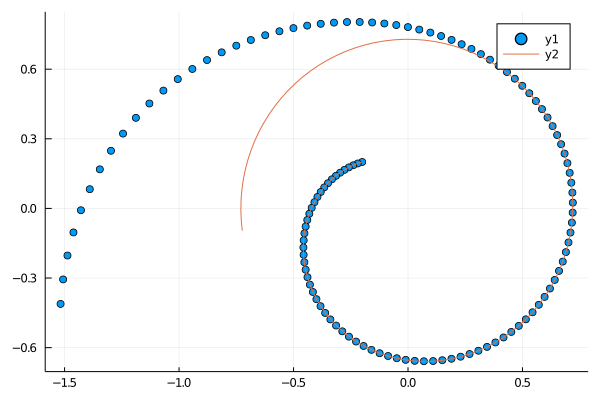

In [13]:
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :])
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :])

## Plot $x(t)$ and $y(t)$

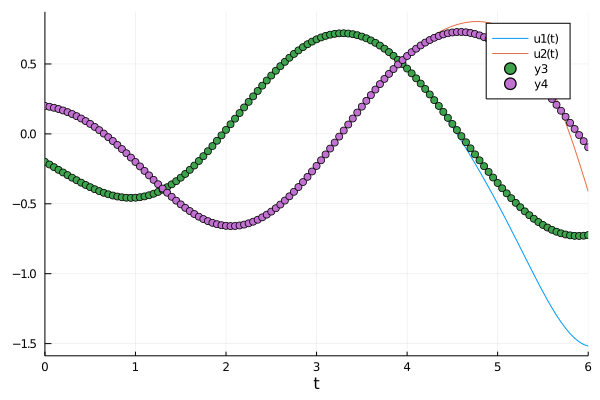

In [14]:
plot(sol_nn2)
scatter!(solution_test.t, Array(solution_test)[1, :])
scatter!(solution_test.t, Array(solution_test)[2, :])

-----------------------------------------
-----------------------------------------
-----------------------------------------

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives:
### we take derivatives with respect to $t$ of $(x(t), y(t))$ both from the known solution and the solution to the trained UADE

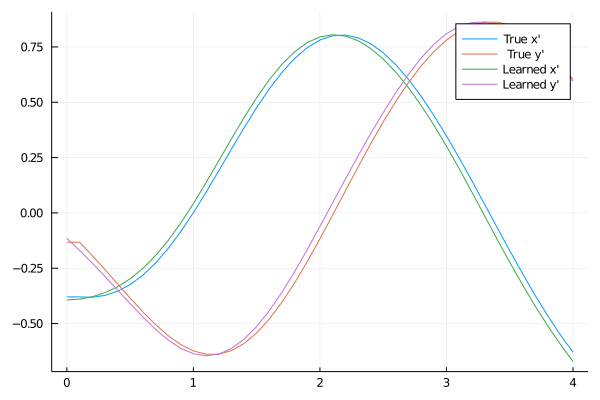

In [15]:
DX = Array(solution(solution.t, Val{1})) 

prob_nn2 = ODEProblem(dudt_, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())

DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["True x'" " True y'"])
plot!(solution.t, DX_', label = ["Learned x'" "Learned y'"])

## The learned derivatives

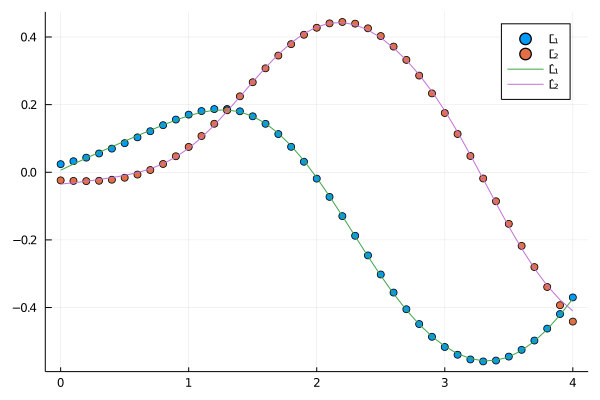

In [47]:
# Ideal data
L̄ = [p_[3]*(Xₙ[1,:].^(3) + Xₙ[1,:].*Xₙ[2,:].^(2))'; p_[4]*(Xₙ[2,:].*Xₙ[1,:].^(2) + Xₙ[2,:].^(3))']

# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

scatter(solution.t, L̄', label = ["L̄₁" "L̄₂"])
plot!(solution.t, L̂', label = ["L̂₁" "L̂₂"])


#savefig("UADE.png")

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

## Create a basis for the sparse identification

In [17]:
@variables u[1:2]

# Lots of polynomials
polys = Operation[1]

for i ∈ 1:5
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:5
        if i != j
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; polys...]
basis = Basis(h, u)

29 dimensional basis in ["u₁", "u₂"]

## Optimizer for the algorithm

In [18]:
opt = SR3() #STRRidge(0.1)


# Create the thresholds which should be used in the search process
λ = exp10.(-7:0.1:3)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge (fail)

In [19]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 10000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 2
Active terms : 2
   Equation 1 : 1
   Equation 2 : 1
Overall error (L2-Norm) : 1.8581787
   Equation 1 : 1.0271385
   Equation 2 : 0.83104026
AICC :
   Equation 1 : 2.208682
   Equation 2 : 3.0560977

SR3{Float64,UnionAll}(0.19905358527674863, 1.0, ProximalOperators.NormL1) did not converge after 10000 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = sin(u₂) * p₁
du₂ = p₂ * u₁



## Test on UADE derivative data

In [20]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 10000, normalize = true, denoise = true)
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 2
Active terms : 2
   Equation 1 : 1
   Equation 2 : 1
Overall error (L2-Norm) : 1.6594245
   Equation 1 : 1.1153065
   Equation 2 : 0.544118
AICC :
   Equation 1 : 1.8878073
   Equation 2 : 4.758681

SR3{Float64,UnionAll}(0.12559432157547898, 1.0, ProximalOperators.NormL1) converged after 5061 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = u₁ ^ 3 * p₁
du₂ = p₂ * u₂



## Extract the parameters

In [22]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[-0.90429634, -0.47142574]


## Define the ODE with the new identified unknown term

In [23]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys);

In [24]:
function dudt(du, u, p, t)
    # Add SINDy Term
    μ, ω, A1, A2 = p
    z = unknown_eq(u, [A1; A2], t)
    du[1] = μ*u[1] - ω*u[1] + z[1]
    du[2] = ω*u[2] + μ*u[2] + z[2]
end

dudt (generic function with 1 method)

## Create the approximated problem and solution

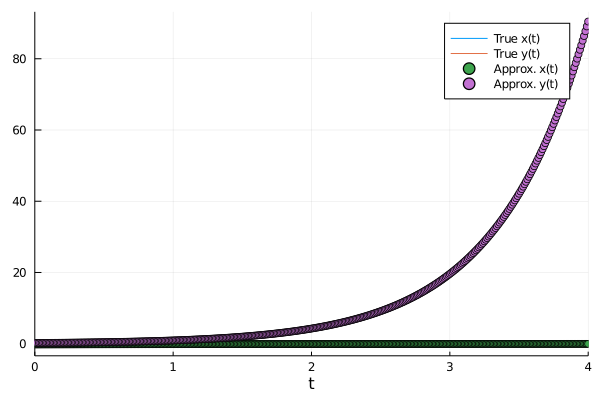

In [25]:
ps = [p_[[1,2]]; p̂]
approximate_prob = ODEProblem(dudt, u0, tspan, ps)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.01)

# Plot
plot(solution, label = ["True x(t)" "True y(t)"])
scatter!(approximate_solution, label = ["Approx. x(t)" "Approx. y(t)"])